# 📊 — Análise Exploratória de Dados (EDA)
## Ligia NLP Challenge — Detecção de Fake News

**Objetivo:** Compreender a estrutura, distribuições e características dos dados textuais antes de qualquer modelagem.

| Informação | Detalhe |
|---|---|
| **Tarefa** | Classificação binária: 0 = Real, 1 = Fake |
| **Dados de Entrada** | `data/raw/train.csv`, `data/raw/test.csv` |
| **Próximo Notebook** | `2.0-preprocessing.ipynb` — Pré-processamento e vetorização |

### O que este notebook cobre
1. Carregamento e inspeção inicial dos dados
2. Estatísticas descritivas (dimensões, tipos, nulos)
3. Distribuição de classes e balanceamento
4. Análise de comprimento textual (title vs text)
5. Wordclouds e n-gramas mais frequentes por classe
6. Padrões temporais e distribuição por `subject`
7. Identificação de **data leakage** (coluna `subject`)
8. Análise de duplicatas
9. Guia de decisões para o pré-processamento

> ⚠️ **Atenção:** A coluna `subject` é um proxy perfeito do `label` — incluí-la como feature causa **data leakage** e deve ser descartada na modelagem.

---


## 1. Importação de Bibliotecas

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np
import os 

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Processamento de texto
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Configuração de exibição do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Download de recursos necessários
nltk.download('stopwords', quiet=True)

True

## 2. Carregamento dos Dados

In [2]:
# Caminhos dos arquivos
DATA_PATH = "../data/raw"
TRAIN_PATH = '../data/raw/train.csv'
TEST_PATH = '../data/raw/test.csv'

# Criar diretório de saída se não existir
os.makedirs(DATA_PATH, exist_ok=True)

# Carregamento dos dados
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

print(f"Shape do conjunto de treino: {df_train.shape}")
print(f"Shape do conjunto de teste: {df_test.shape}")

Shape do conjunto de treino: (22844, 6)
Shape do conjunto de teste: (5712, 5)


## 3. Visão Geral dos Dados

In [3]:
# Primeiras linhas do dataset de treino
df_train.head(3)

,id,title,text,subject,date,label
0,13355,"Exclusive: Pentagon, Lockheed near deal on $9 billion F-35 contract - sources",WASHINGTON (Reuters) - The U.S. Department of Defense and Lockheed Martin Corp (LMT.N) are close...,politicsNews,"January 19, 2017",0
1,2113,“HILL”ARIOUS…MUST SEE! IOWA PARADE GOERS Treated To “Hillary In Prison” Float…Water Balloon Pass...,"HILL larious! If this was a Donald Trump pi ata, the media would be all over this story, making...",left-news,"Aug 3, 2016",1
2,27667,Philippine leader says 'no way' he'll do deal with Islamist rebels,MANILA (Reuters) - Philippine President Rodrigo Duterte on Saturday ruled out the possibility of...,worldnews,"September 9, 2017",0


In [4]:
# Informações gerais
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22844 entries, 0 to 22843
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       22844 non-null  int64 
 1   title    22844 non-null  object
 2   text     22844 non-null  object
 3   subject  22844 non-null  object
 4   date     22844 non-null  object
 5   label    22844 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.0+ MB


## 4. Análise de Valores Faltantes

In [5]:
# Quantos com "video" no título têm texto vazio
video_empty_train = df_train[df_train['title'].str.contains('video', case=False, na=False) & df_train['text'].fillna('').str.strip().eq('')]
video_empty_test = df_test[df_test['title'].str.contains('video', case=False, na=False) & df_test['text'].fillna('').str.strip().eq('')]

print(f"Treino: {len(video_empty_train)}")
print(f"Teste: {len(video_empty_test)}")


# Análise dos rótulos das amostras com 'video' no título e texto vazio
print("="*80)
print("ANÁLISE DOS RÓTULOS - AMOSTRAS COM 'VIDEO' NO TÍTULO E TEXTO VAZIO")
print("="*80)

print("\n--- TREINO ---")
label_counts_train = video_empty_train['label'].value_counts().sort_index()
label_pct_train = video_empty_train['label'].value_counts(normalize=True).sort_index() * 100
label_names = {0: 'Real', 1: 'Fake'}

for lbl in label_counts_train.index:
    print(f"{label_names[lbl]:5s}: {label_counts_train[lbl]:3d} ({label_pct_train[lbl]:5.1f}%)")


# Amostra do treino
print("\n" + "="*80)
print("AMOSTRA")
print("="*80)
print(video_empty_train[['title', 'subject', 'label']].head(5).to_string())

Treino: 123
Teste: 31
ANÁLISE DOS RÓTULOS - AMOSTRAS COM 'VIDEO' NO TÍTULO E TEXTO VAZIO

--- TREINO ---
Fake : 123 (100.0%)

AMOSTRA
                                                                                                       title          subject  label
29                                    LOL! NANCY PELOSI: “I’m not sure if ironically is even a word” [Video]         politics      1
61   Howard Dean: Democratic Party’s Tent Not Big Enough For Pro-Lifers But All About Social Justice [Video]         politics      1
204                                       EPIC CONSERVATIVE Take Down After CNN Ambush Of Radio Host [Video]         politics      1
384                                   UNDERCOVER JOURNALIST In Burka Is Offered Huma Abedin’s Ballot [Video]        left-news      1
551                        WATCH MAJOR MOMENT President-elect Trump And Entire Family Arrive In D.C. [Video]  Government News      1


### 4.1 Verificação do Conteúdo do Texto



In [6]:
checks = {
    'HTML tags':       r'<[^>]+>',
    'URLs':            r'https?://\S+|www\.\S+',
    'Emails':          r'\S+@\S+\.\S+',
    'Menções (@)':     r'@\w+',
    'Hashtags (#)':    r'#\w+',
    'Texto vazio':     r'^\s*$',
}

print("=" * 80)
print("VERIFICAÇÃO DE SUJEIRA NO TEXTO")
print("=" * 80)
for name, pattern in checks.items():
    count_text = df_train['text'].str.contains(pattern, regex=True, na=False).sum()
    count_title = df_train['title'].str.contains(pattern, regex=True, na=False).sum()
    flag = "⚠️" if (count_text + count_title) > 0 else "✅"
    print(f"  {flag} {name:20s} → text: {count_text:>5d}  |  title: {count_title:>5d}")

VERIFICAÇÃO DE SUJEIRA NO TEXTO
  ⚠️ HTML tags            → text:    25  |  title:     0
  ⚠️ URLs                 → text:   863  |  title:     2
  ⚠️ Emails               → text:    18  |  title:     0
  ⚠️ Menções (@)          → text:  1670  |  title:     3
  ⚠️ Hashtags (#)         → text:   926  |  title:   190
  ⚠️ Texto vazio          → text:   154  |  title:     0


## 5. Distribuição das Classes (Subject)

In [7]:
# Distribuição de subjects no conjunto de treino
subject_counts = df_train['subject'].value_counts()
print(subject_counts)
print(f"\nTotal de categorias únicas: {df_train['subject'].nunique()}")

subject
politicsNews       9028
worldnews          8105
News               2206
politics           1644
left-news          1071
Government News     403
US_News             197
Middle-east         190
Name: count, dtype: int64

Total de categorias únicas: 8


## 6. Análise de Comprimento dos Textos por classe


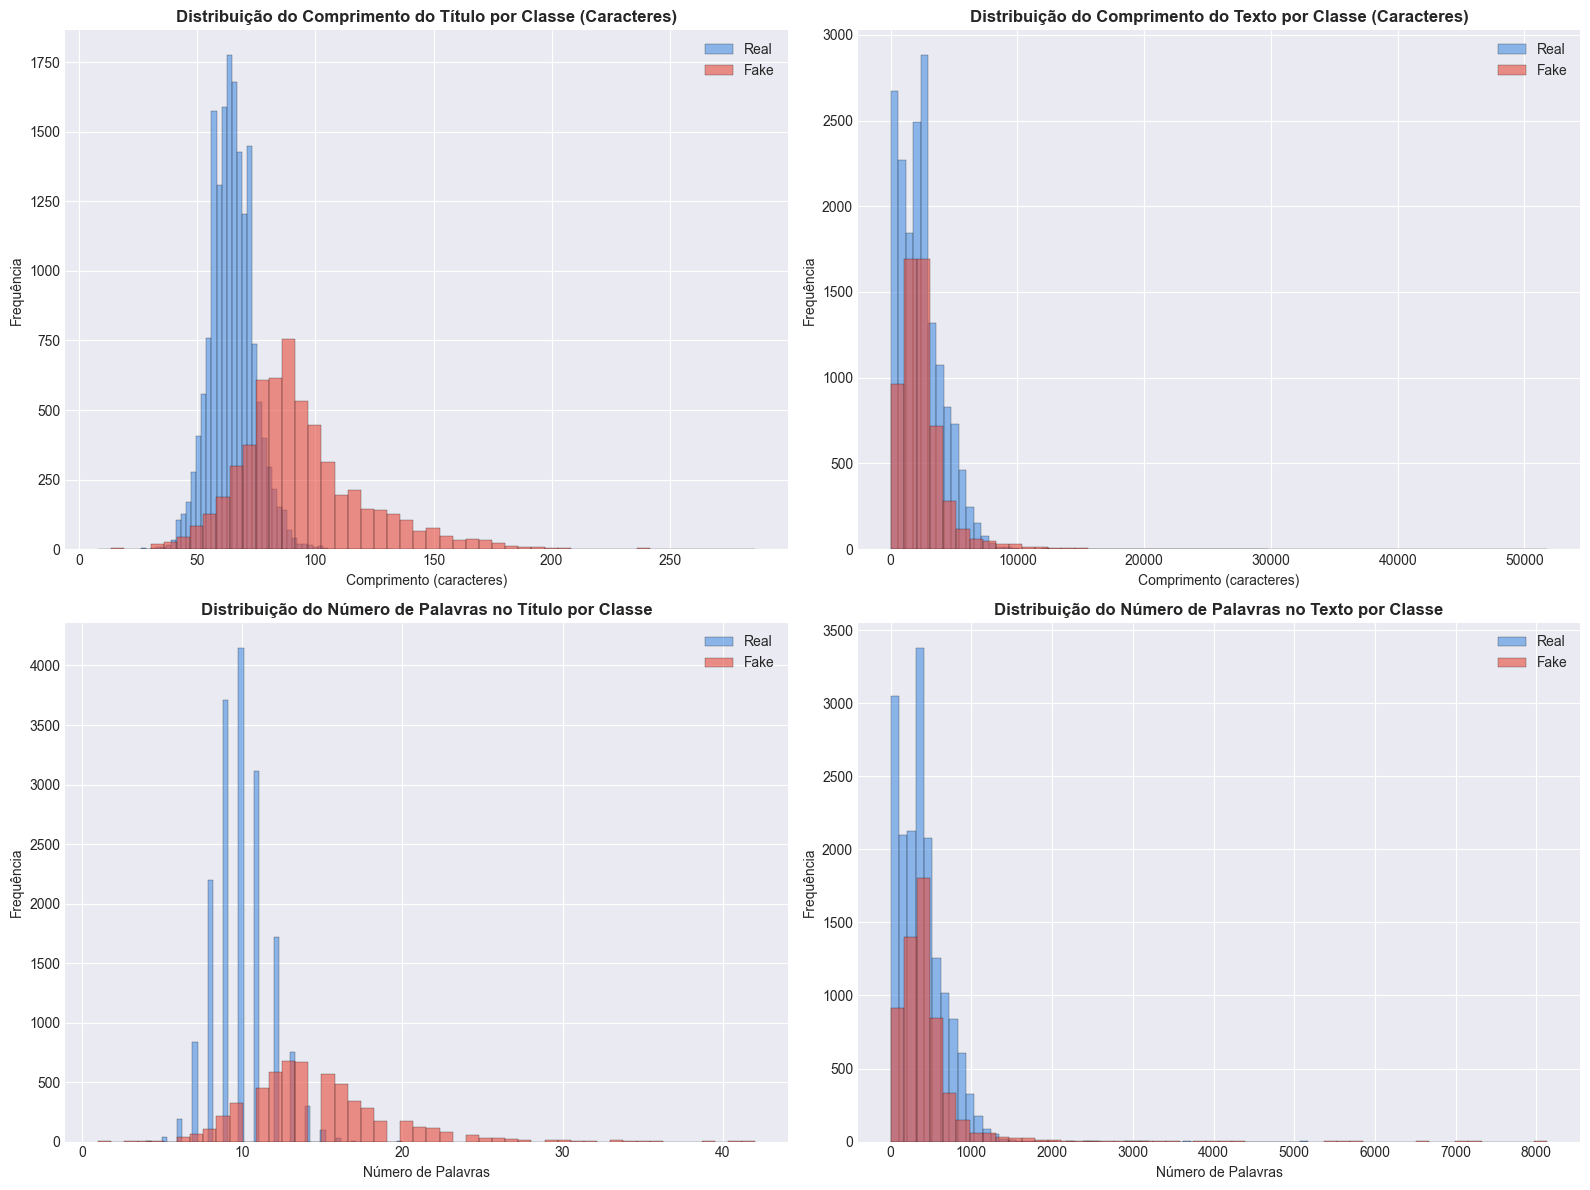

In [8]:
# Visualização de distribuições de comprimento por label
df_train['title_length'] = df_train['title'].fillna('').str.len()
df_train['text_length'] = df_train['text'].fillna('').str.len()
df_train['title_word_count'] = df_train['title'].fillna('').str.split().apply(len)
df_train['text_word_count'] = df_train['text'].fillna('').str.split().apply(len)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
label_names_local = globals().get("label_names", {0: "Real", 1: "Fake"})
colors = {0: '#4A90E2', 1: '#E74C3C'}
bins = 50

# Title length por label
for lbl in [0, 1]:
    subset = df_train[df_train['label'] == lbl]['title_length'].dropna()
    axes[0, 0].hist(subset, bins=bins, alpha=0.6, label=label_names_local.get(lbl, str(lbl)),
                    color=colors[lbl], edgecolor='black', linewidth=0.3)
axes[0, 0].set_title('Distribuição do Comprimento do Título por Classe (Caracteres)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Comprimento (caracteres)')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].legend()

# Text length por label
for lbl in [0, 1]:
    subset = df_train[df_train['label'] == lbl]['text_length'].dropna()
    axes[0, 1].hist(subset, bins=bins, alpha=0.6, label=label_names_local.get(lbl, str(lbl)),
                    color=colors[lbl], edgecolor='black', linewidth=0.3)
axes[0, 1].set_title('Distribuição do Comprimento do Texto por Classe (Caracteres)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Comprimento (caracteres)')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].legend()

# Title word count por label
for lbl in [0, 1]:
    subset = df_train[df_train['label'] == lbl]['title_word_count'].dropna()
    axes[1, 0].hist(subset, bins=bins, alpha=0.6, label=label_names_local.get(lbl, str(lbl)),
                    color=colors[lbl], edgecolor='black', linewidth=0.3)
axes[1, 0].set_title('Distribuição do Número de Palavras no Título por Classe', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Número de Palavras')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].legend()

# Text word count por label
for lbl in [0, 1]:
    subset = df_train[df_train['label'] == lbl]['text_word_count'].dropna()
    axes[1, 1].hist(subset, bins=bins, alpha=0.6, label=label_names_local.get(lbl, str(lbl)),
                    color=colors[lbl], edgecolor='black', linewidth=0.3)
axes[1, 1].set_title('Distribuição do Número de Palavras no Texto por Classe', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Número de Palavras')
axes[1, 1].set_ylabel('Frequência')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


## 8. Análise Temporal

In [9]:
# Parsing de datas e criação de features temporais
df_train['date_parsed'] = pd.to_datetime(df_train['date'], format='mixed', errors='coerce')

valid = df_train['date_parsed'].notna().sum()


# Extrair componentes temporais
df_train['year'] = df_train['date_parsed'].dt.year
df_train['month'] = df_train['date_parsed'].dt.month
df_train['day_of_week'] = df_train['date_parsed'].dt.day_name()
df_train['quarter'] = df_train['date_parsed'].dt.quarter
df_train['semester'] = df_train['month'].apply(lambda x: 1 if pd.notna(x) and x <= 6 else (2 if pd.notna(x) else np.nan))
df_train['is_weekend'] = df_train['date_parsed'].dt.dayofweek >= 5

print(f"\nFeatures temporais criadas: year, month, day_of_week, quarter, semester, is_weekend")


Features temporais criadas: year, month, day_of_week, quarter, semester, is_weekend


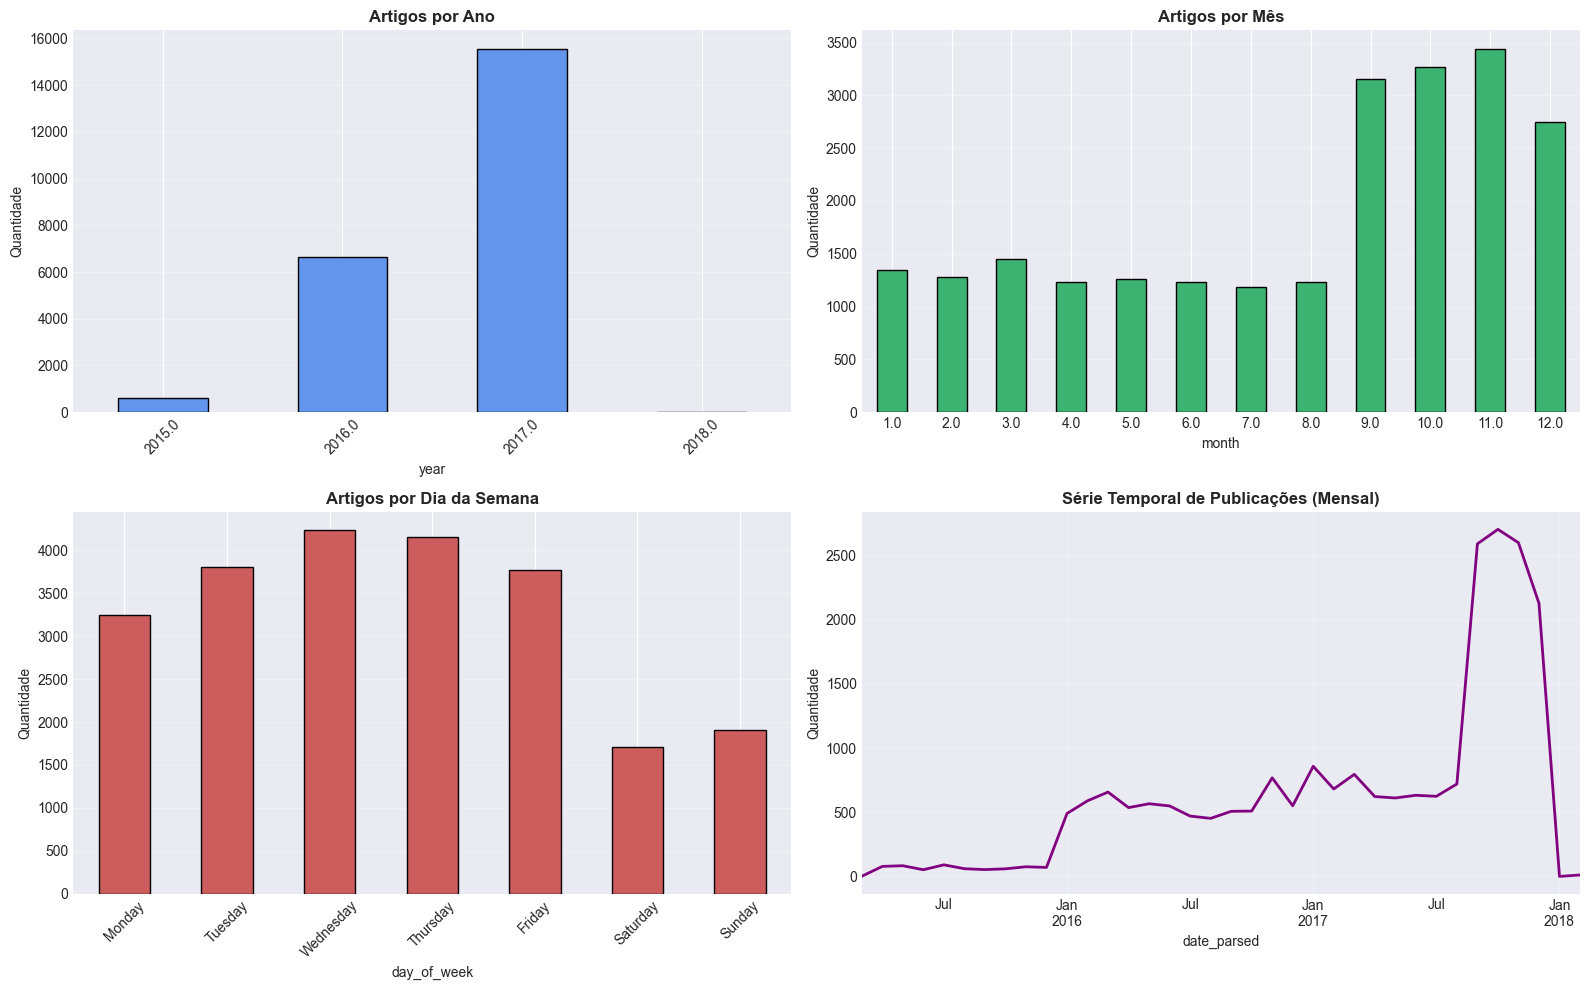

DISTRIBUIÇÃO POR SEMESTRE E TRIMESTRE

Semestre:
semester
1.0     7811
2.0    15030

Trimestre:
quarter
1.0    4082
2.0    3729
3.0    5567
4.0    9463

Fim de semana: 3620 (15.8%)


In [10]:
# Distribuições temporais
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Por ano
year_counts = df_train['year'].value_counts().sort_index()
year_counts.plot(kind='bar', ax=axes[0, 0], color='cornflowerblue', edgecolor='black')
axes[0, 0].set_title('Artigos por Ano', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Quantidade')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Por mês
month_counts = df_train['month'].value_counts().sort_index()
month_counts.plot(kind='bar', ax=axes[0, 1], color='mediumseagreen', edgecolor='black')
axes[0, 1].set_title('Artigos por Mês', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Quantidade')
axes[0, 1].tick_params(axis='x', rotation=0)
axes[0, 1].grid(axis='y', alpha=0.3)

# Por dia da semana
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df_train['day_of_week'].value_counts().reindex(day_order, fill_value=0)
day_counts.plot(kind='bar', ax=axes[1, 0], color='indianred', edgecolor='black')
axes[1, 0].set_title('Artigos por Dia da Semana', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Quantidade')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Série temporal mensal
df_sorted = df_train.dropna(subset=['date_parsed']).sort_values('date_parsed')
df_sorted.set_index('date_parsed').resample('ME').size().plot(ax=axes[1, 1], color='purple', linewidth=2)
axes[1, 1].set_title('Série Temporal de Publicações (Mensal)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Quantidade')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Resumo quantitativo por semestre e trimestre
print("=" * 80)
print("DISTRIBUIÇÃO POR SEMESTRE E TRIMESTRE")
print("=" * 80)
print(f"\nSemestre:\n{df_train['semester'].value_counts().sort_index().to_string()}")
print(f"\nTrimestre:\n{df_train['quarter'].value_counts().sort_index().to_string()}")
print(f"\nFim de semana: {df_train['is_weekend'].sum()} ({df_train['is_weekend'].mean()*100:.1f}%)")

## 9. Análise de Texto - Palavras Mais Frequentes

In [11]:
# Função para preprocessar texto
def preprocess_text(text, remove_stopwords=True):
    """
    Preprocessa texto: lowercase, remove pontuação, remove stopwords
    """
    if pd.isna(text):
        return ""
    
    # Lowercase
    text = str(text).lower()
    
    # Remove pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenização
    tokens = text.split()
    
    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

# Aplicar preprocessamento
df_train['text_processed'] = df_train['text'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
df_train['title_processed'] = df_train['title'].apply(lambda x: preprocess_text(x, remove_stopwords=True))


## 10. Nuvem de Palavras

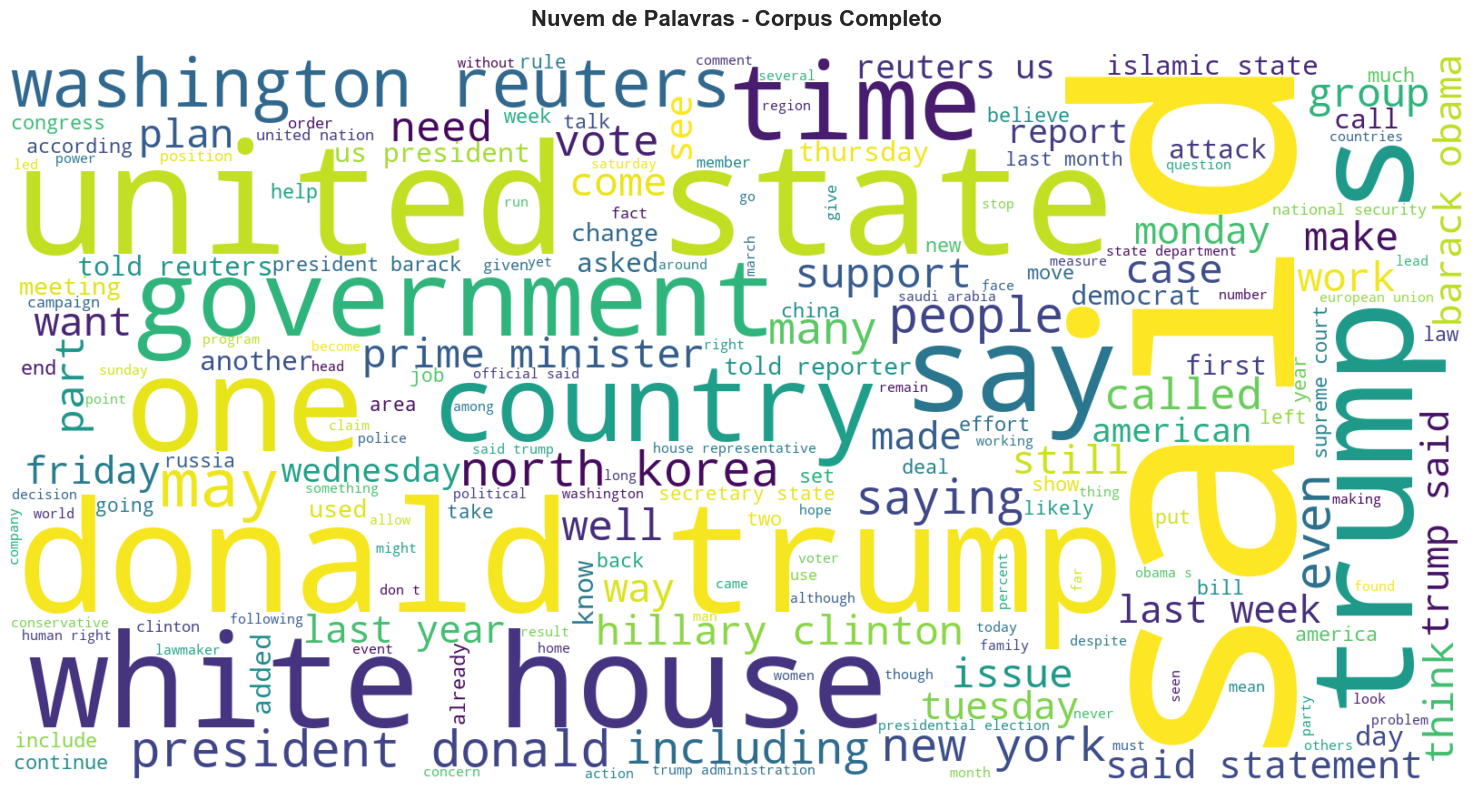

In [12]:
# Nuvem de palavras para todo o corpus
all_text = ' '.join(df_train['text_processed'].fillna(''))

wordcloud = WordCloud(width=1600, height=800, 
                     background_color='white',
                     colormap='viridis',
                     max_words=200).generate(all_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras - Corpus Completo', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

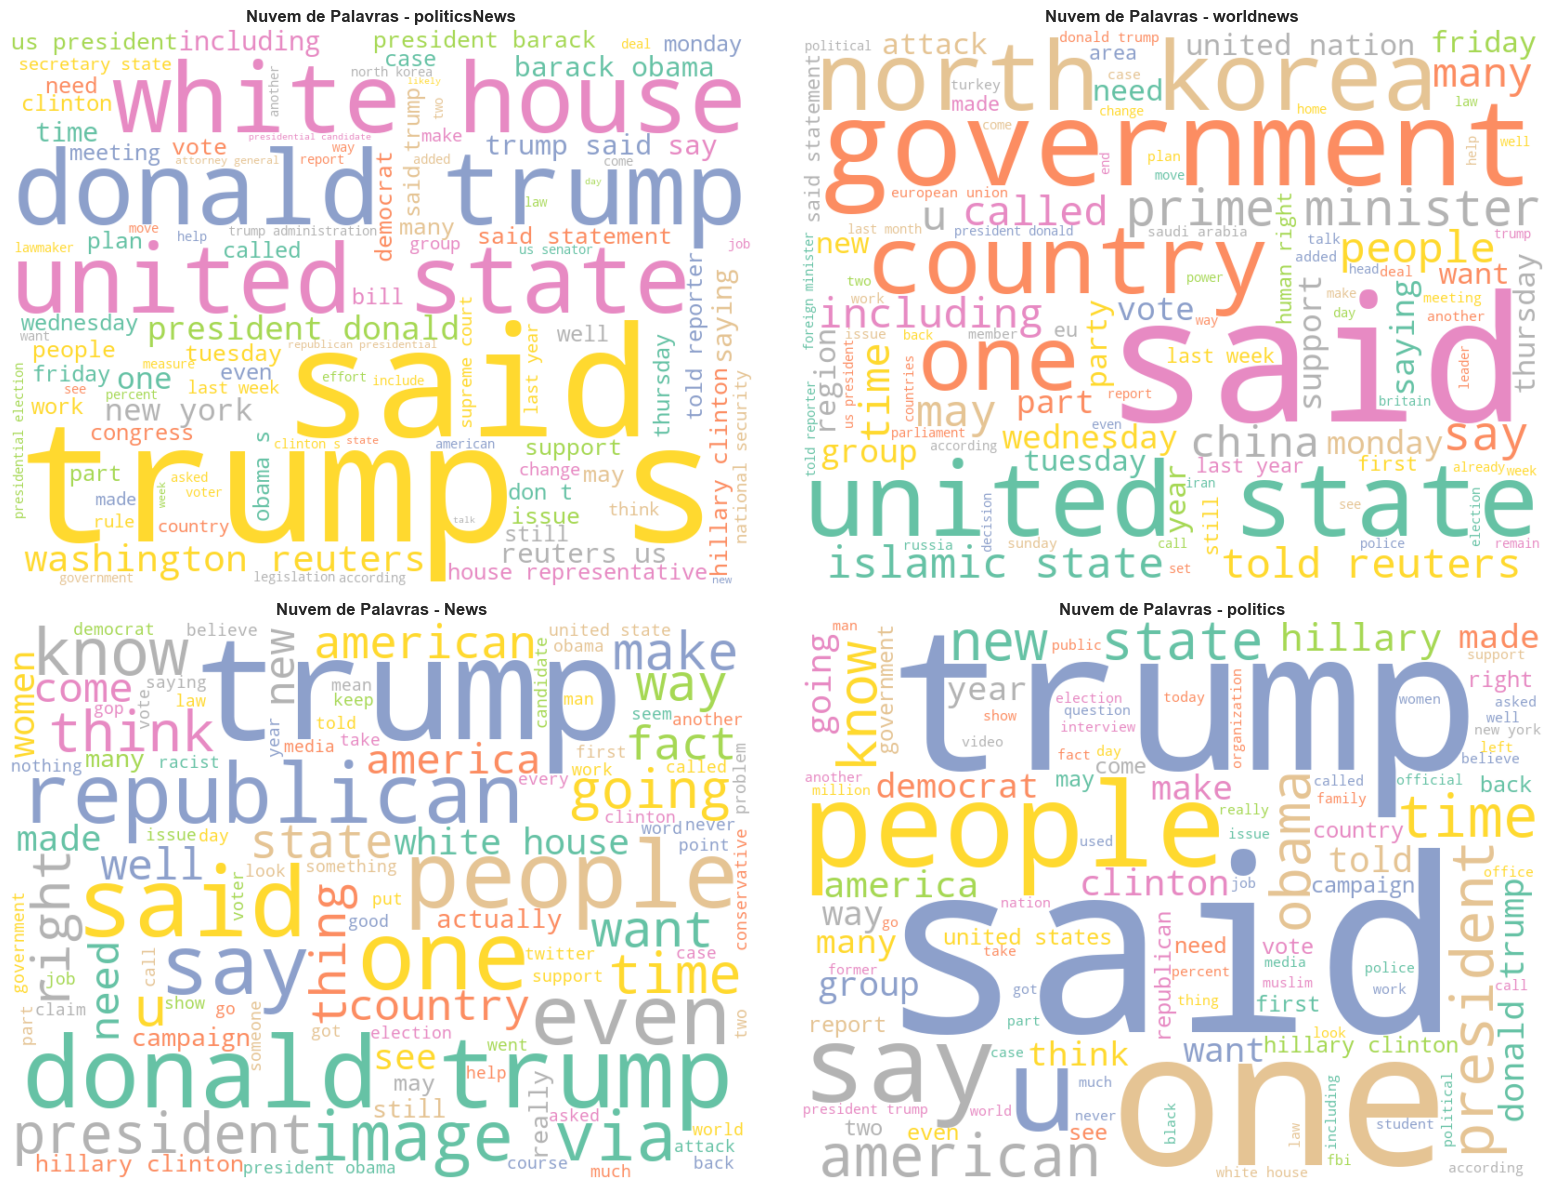

In [13]:
# Nuvem de palavras por subject (principais categorias)
top_subjects = df_train['subject'].value_counts().head(4).index

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, subject in enumerate(top_subjects):
    subject_text = ' '.join(df_train[df_train['subject'] == subject]['text_processed'].fillna(''))
    
    wordcloud = WordCloud(width=800, height=600,
                         background_color='white',
                         colormap='Set2',
                         max_words=100).generate(subject_text)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f'Nuvem de Palavras - {subject}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 11. Análise de Bigramas e Trigramas

In [14]:
# Função para extrair n-gramas
def get_ngrams(texts, n=2, top_k=20):
    """
    Extrai os top_k n-gramas mais frequentes
    """
    from nltk import ngrams
    
    all_ngrams = []
    for text in texts:
        if pd.notna(text):
            words = str(text).split()
            all_ngrams.extend(list(ngrams(words, n)))
    
    ngram_freq = Counter(all_ngrams)
    return ngram_freq.most_common(top_k)

# Bigramas
top_bigrams = get_ngrams(df_train['text_processed'].fillna(''), n=2, top_k=20)

# Trigramas
top_trigrams = get_ngrams(df_train['text_processed'].fillna(''), n=3, top_k=20)

print("="*80)
print("TOP 20 BIGRAMAS")
print("="*80)
for ngram, count in top_bigrams:
    print(f"{' '.join(ngram):40s}: {count}")

print("\n" + "="*80)
print("TOP 20 TRIGRAMAS")
print("="*80)
for ngram, count in top_trigrams:
    print(f"{' '.join(ngram):50s}: {count}")

TOP 20 BIGRAMAS
united states                           : 10966
donald trump                            : 9551
white house                             : 8085
washington reuters                      : 5211
president donald                        : 4974
new york                                : 4462
north korea                             : 4426
prime minister                          : 3398
hillary clinton                         : 3307
said statement                          : 3246
trump said                              : 3030
reuters us                              : 2926
last week                               : 2915
us president                            : 2845
told reuters                            : 2824
last year                               : 2819
islamic state                           : 2769
told reporters                          : 2633
said would                              : 2554
president barack                        : 2543

TOP 20 TRIGRAMAS
president donald trump   

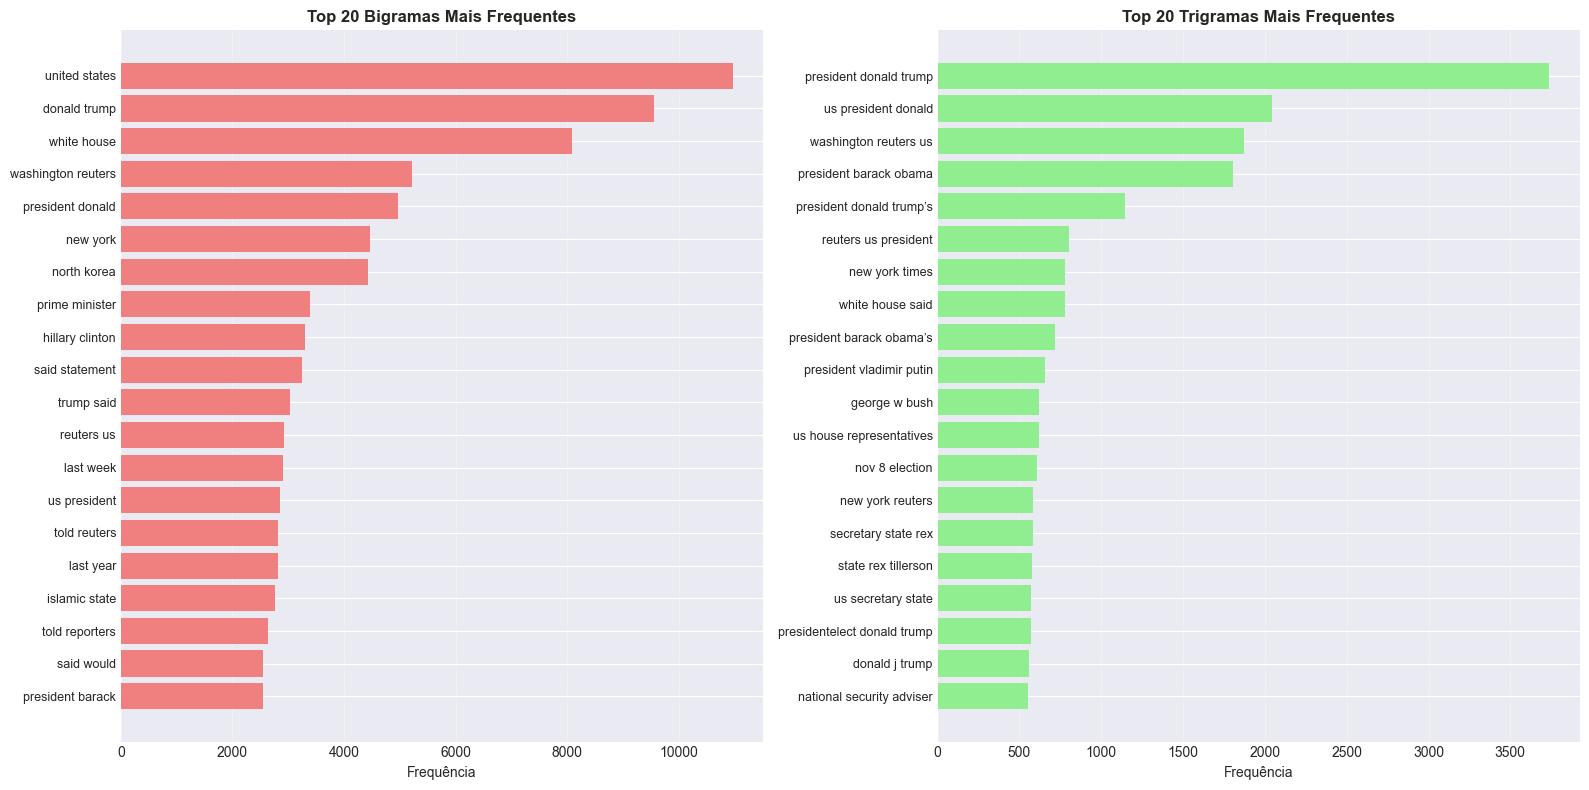

In [15]:
# Visualização de bigramas e trigramas
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bigramas
bigram_labels = [' '.join(bg) for bg, _ in top_bigrams]
bigram_counts = [count for _, count in top_bigrams]

axes[0].barh(range(len(bigram_labels)), bigram_counts, color='lightcoral')
axes[0].set_yticks(range(len(bigram_labels)))
axes[0].set_yticklabels(bigram_labels, fontsize=9)
axes[0].set_xlabel('Frequência')
axes[0].set_title('Top 20 Bigramas Mais Frequentes', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Trigramas
trigram_labels = [' '.join(tg) for tg, _ in top_trigrams]
trigram_counts = [count for _, count in top_trigrams]

axes[1].barh(range(len(trigram_labels)), trigram_counts, color='lightgreen')
axes[1].set_yticks(range(len(trigram_labels)))
axes[1].set_yticklabels(trigram_labels, fontsize=9)
axes[1].set_xlabel('Frequência')
axes[1].set_title('Top 20 Trigramas Mais Frequentes', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Análise de Duplicatas

In [16]:
# Verificar duplicatas
print("="*80)
print("ANÁLISE DE DUPLICATAS")
print("="*80)

# Duplicatas exatas (todas as colunas)
duplicates_all = df_train.duplicated().sum()
print(f"Duplicatas exatas (todas as colunas): {duplicates_all}")

# Duplicatas em texto
duplicates_text = df_train.duplicated(subset=['text']).sum()
print(f"Duplicatas em texto: {duplicates_text}")

# Duplicatas em título
duplicates_title = df_train.duplicated(subset=['title']).sum()
print(f"Duplicatas em título: {duplicates_title}")

# Duplicatas em ID
duplicates_id = df_train.duplicated(subset=['id']).sum()
print(f"Duplicatas em ID: {duplicates_id}")

ANÁLISE DE DUPLICATAS
Duplicatas exatas (todas as colunas): 0
Duplicatas em texto: 649
Duplicatas em título: 741
Duplicatas em ID: 0


## 13. Análise do Target (Label) — Balanceamento e Distribuição por Classe

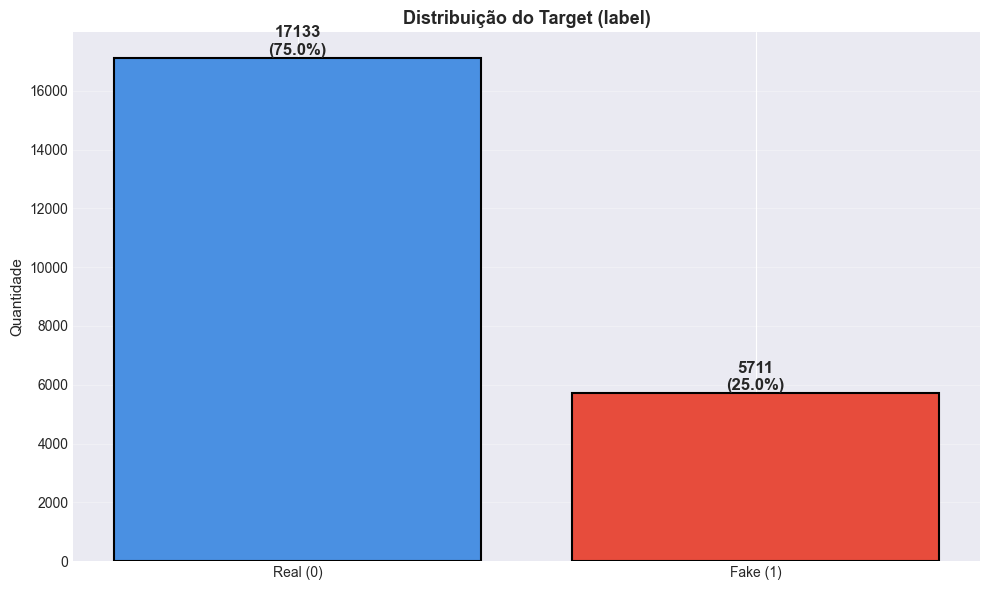

In [17]:
# 14.1 — Balanceamento de Classes
label_counts = df_train['label'].value_counts().sort_index()
label_pct = df_train['label'].value_counts(normalize=True).sort_index() * 100
label_names = {0: 'Real (0)', 1: 'Fake (1)'}

fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot with percentages
bars = ax.bar([label_names[i] for i in label_counts.index],
              label_counts.values,
              color=['#4A90E2', '#E74C3C'], edgecolor='black', linewidth=1.5)

# Add count and percentage labels
for i, (bar, count, pct) in enumerate(zip(bars, label_counts.values, label_pct.values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{int(count)}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_title('Distribuição do Target (label)', fontsize=13, fontweight='bold')
ax.set_ylabel('Quantidade', fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [18]:
# 14.3 — Distribuição de Subject por Classe (Real vs Fake)
label_names = {0: 'Real', 1: 'Fake'}

ct = pd.crosstab(df_train['subject'], df_train['label'])
ct.columns = [label_names[c] for c in ct.columns]
ct['Total'] = ct.sum(axis=1)
ct_pct = ct[['Real', 'Fake']].div(ct['Total'], axis=0) * 100

print("=" * 80)
print("SUBJECTS POR CLASSE (contagem)")
print("=" * 80)
print(ct.sort_values('Total', ascending=False))

print("\n" + "=" * 80)
print("SUBJECTS POR CLASSE (% dentro de cada subject)")
print("=" * 80)
print(ct_pct.sort_values('Fake', ascending=False).round(1))

# Insight: subjects exclusivos de uma classe?
exclusive_real = ct_pct[ct_pct['Fake'] == 0].index.tolist()
exclusive_fake = ct_pct[ct_pct['Real'] == 0].index.tolist()
if exclusive_real:
    print(f"\nSubjects 100% REAL: {exclusive_real}")
if exclusive_fake:
    print(f"Subjects 100% FAKE: {exclusive_fake}")

SUBJECTS POR CLASSE (contagem)
                 Real  Fake  Total
subject                           
politicsNews     9028     0   9028
worldnews        8105     0   8105
News                0  2206   2206
politics            0  1644   1644
left-news           0  1071   1071
Government News     0   403    403
US_News             0   197    197
Middle-east         0   190    190

SUBJECTS POR CLASSE (% dentro de cada subject)
                  Real   Fake
subject                      
Government News    0.0  100.0
Middle-east        0.0  100.0
News               0.0  100.0
US_News            0.0  100.0
left-news          0.0  100.0
politics           0.0  100.0
politicsNews     100.0    0.0
worldnews        100.0    0.0

Subjects 100% REAL: ['politicsNews', 'worldnews']
Subjects 100% FAKE: ['Government News', 'Middle-east', 'News', 'US_News', 'left-news', 'politics']


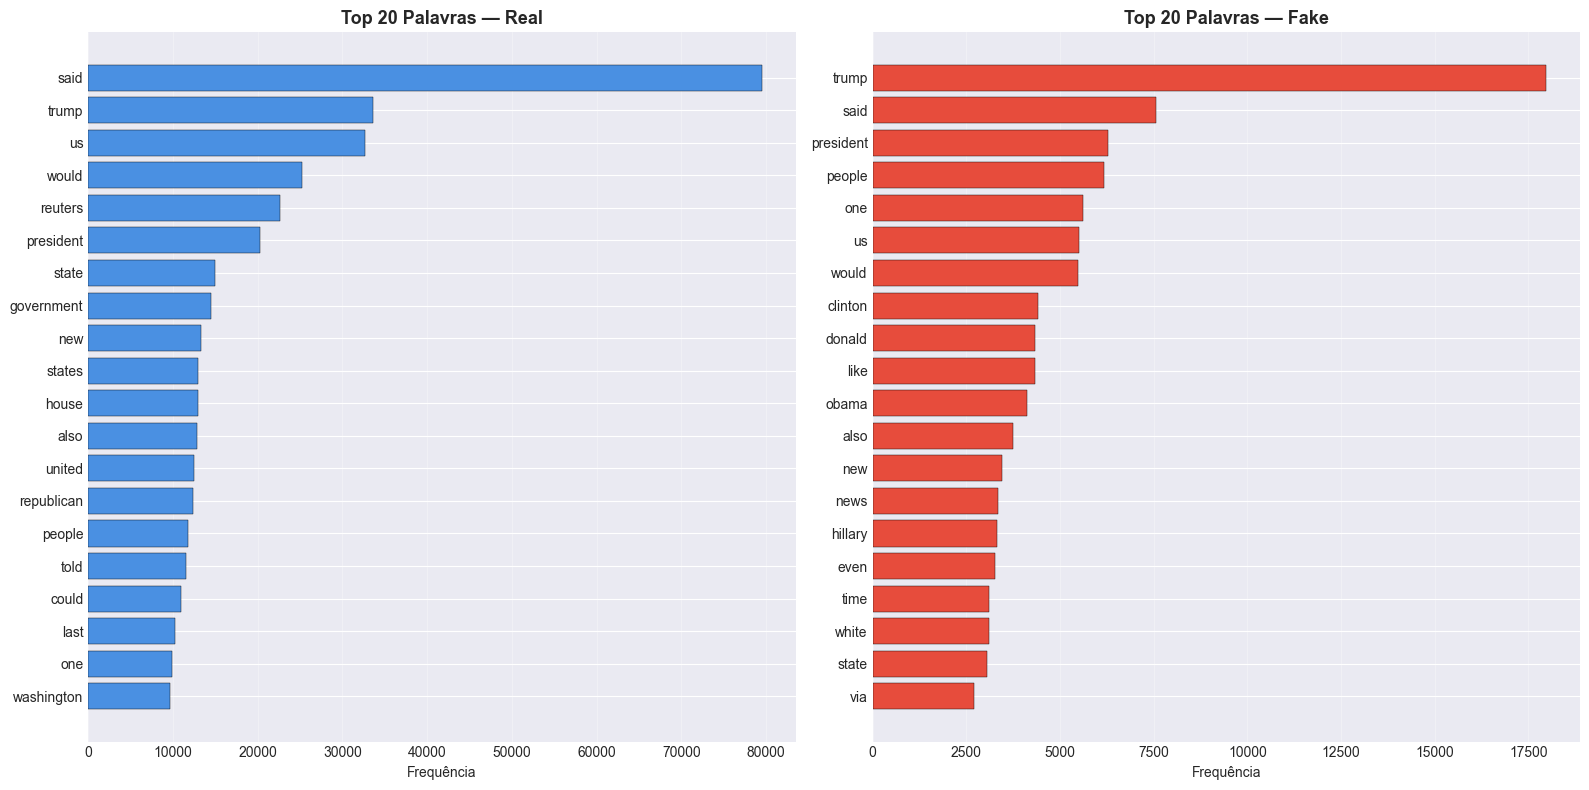

PALAVRAS MAIS DISCRIMINATIVAS (min. 100 ocorrências)

Palavra                 Ratio     Real     Fake
--------------------------------------------------
--- Mais associadas a REAL ---
—                      -1.000      321        0
party’s                -1.000      913        0
“it                    -1.000     1002        0
scalia’s               -1.000      104        0
there’s                -1.000      299        0
kuala                  -1.000      116        0
“my                    -1.000      186        0
didn’t                 -1.000      341        0
biofuels               -1.000      142        0
campaign’s             -1.000      144        0

--- Mais associadas a FAKE ---
boiler                  0.989        3      175
subscribe               0.989        2      127
screenshot              0.992        3      250
getty                   0.997        1      267
21wire                  1.000        0      301
2017realdonaldtrump     1.000        0      361
21wiretv        

In [20]:
# 14.5 — Palavras Mais Frequentes por Classe
label_names = {0: 'Real', 1: 'Fake'}
n_top = 20

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for idx, lbl in enumerate([0, 1]):
    subset_text = df_train[df_train['label'] == lbl]['text_processed'].fillna('')
    all_words = ' '.join(subset_text).split()
    freq = Counter(all_words).most_common(n_top)
    words_list, counts_list = zip(*freq)

    color = '#4A90E2' if lbl == 0 else '#E74C3C'
    axes[idx].barh(range(len(words_list)), counts_list, color=color, edgecolor='black', linewidth=0.3)
    axes[idx].set_yticks(range(len(words_list)))
    axes[idx].set_yticklabels(words_list, fontsize=10)
    axes[idx].set_xlabel('Frequência')
    axes[idx].set_title(f'Top {n_top} Palavras — {label_names[lbl]}', fontsize=13, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Palavras discriminativas: presentes em uma classe mas raras na outra
real_words = Counter(' '.join(df_train[df_train['label'] == 0]['text_processed'].fillna('')).split())
fake_words = Counter(' '.join(df_train[df_train['label'] == 1]['text_processed'].fillna('')).split())

# Ratio de frequência normalizada
total_real = sum(real_words.values())
total_fake = sum(fake_words.values())

discriminative = []
all_keys = set(list(real_words.keys())[:5000]) | set(list(fake_words.keys())[:5000])
for w in all_keys:
    r = real_words.get(w, 0) / total_real
    f = fake_words.get(w, 0) / total_fake
    if r + f > 0:
        ratio = (f - r) / (f + r)  # -1 = só real, +1 = só fake
        if real_words.get(w, 0) + fake_words.get(w, 0) > 100:  # filtrar palavras raras
            discriminative.append((w, ratio, real_words.get(w, 0), fake_words.get(w, 0)))

discriminative.sort(key=lambda x: x[1])
print("=" * 80)
print("PALAVRAS MAIS DISCRIMINATIVAS (min. 100 ocorrências)")
print("=" * 80)

print(f"\n{'Palavra':20s} {'Ratio':>8s} {'Real':>8s} {'Fake':>8s}")
print("-" * 50)
print("--- Mais associadas a REAL ---")
for w, ratio, rc, fc in discriminative[:10]:
    print(f"{w:20s} {ratio:>8.3f} {rc:>8d} {fc:>8d}")

print("\n--- Mais associadas a FAKE ---")
for w, ratio, rc, fc in discriminative[-10:]:
    print(f"{w:20s} {ratio:>8.3f} {rc:>8d} {fc:>8d}")

---

## Conclusões da EDA

**Estrutura do dataset:**
- 22.844 amostras de treino com 6 colunas originais: `id`, `title`, `text`, `subject`, `date`, `label`
- Target binário: `label` (0 = Real, 1 = Fake)
- Sem valores faltantes significativos

**Principais achados:**
- **Balanceamento:** observar se é necessario rebalanceamento, pois existe uma desporporção
- **Subject como proxy do label:** subjects são exclusivos de uma classe (ex: `politicsNews` = 100% Real, `left-news` = 100% Fake) — usar `subject` como feature causaria **data leakage**
- **Comprimento do texto:** notícias reais tendem a ser mais longas que fake news (média e mediana consistentes)
- **Padrões temporais:** distribuição temporal difere entre classes — pode ser sinal real ou artefato do dataset
- **Duplicatas:**  Existem duplicatas

---